In [1]:
import os
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load dataset
DATA_DIR_PATH = "dataset"
DATA_PATH = os.path.join(DATA_DIR_PATH, 'animal-faces')
DATA_URL = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces/download?datasetVersionNumber=1'
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [3]:
root_dir = os.path.join(DATA_PATH, "train")
subdir = os.listdir(root_dir)
image_names = []
for category in subdir:
    subdir_path = os.path.join(root_dir, category)
    image_names+=os.listdir(subdir_path)

In [4]:
class AnimalfaceDataset(Dataset):
    def __init__(self, type='train', transform=None, label_dict = {"dog":0, "cat":1, "wild":2}) -> None:
        self.transform = transform
        # self.root_dir specifies weather you are at afhq/train or afhq/val directory
        self.label_dict = label_dict
        self.root_dir = os.path.join(DATA_PATH, type)
        assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
        subdir = os.listdir(self.root_dir)
        self.image_names = []
        
        for category in subdir:
            subdir_path = os.path.join(self.root_dir, category)
            self.image_names+=os.listdir(subdir_path)
        
    
    def __getitem__(self, idx):
        # Get the path to the image 
        img_name = self.image_names[idx]
        label = self.label_dict[img_name.split("_")[1]]
        img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
        # Load image and convert it to RGB
        img = Image.open(img_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        return img, label
    
    def __len__(self):
        return len(self.image_names)
    

In [5]:
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((128,128))])
train_data = AnimalfaceDataset(transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
val_data = AnimalfaceDataset(transform=transform, type="val")
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
x, y = next(iter(train_loader))
x.shape, y.shape

/home/karm/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([128, 3, 128, 128]), torch.Size([128]))

In [12]:
class Encoder(nn.Module):
    def __init__(self, conv_op_size = (32,6,6), enc_op_size=1024):
        super(Encoder, self).__init__()
        self.conv_layer = nn.Sequential(
                nn.Conv2d(3, 8, 7, stride=2),
                nn.ReLU(True),
                nn.Conv2d(8, 16, 5, stride=2),
                nn.BatchNorm2d(16),
                nn.ReLU(True),
                nn.Conv2d(16, 32, 3, stride=2),
                nn.ReLU(True),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(True)
        )
        
        self.liner_layer = nn.Sequential(nn.Linear(conv_op_size[0]*conv_op_size[1]*conv_op_size[2], enc_op_size))
        
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.flatten(start_dim=1)
        x = self.liner_layer(x)
        return x
    
e = Encoder()
eo = e(x)
eo.shape

torch.Size([128, 1024])

In [13]:
class Decoder(nn.Module):
    def __init__(self, conv_op_size = (32,14,14), dec_ip_size=1024):
        super(Decoder, self).__init__()
        self.conv_layer = nn.Sequential(            
            nn.ConvTranspose2d(32, 32, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 7, stride=2, output_padding=1)
        )
        
        self.liner_layer = nn.Sequential(nn.Linear(dec_ip_size, conv_op_size[0]*conv_op_size[1]*conv_op_size[2]))
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        x = self.liner_layer(x)
        x = self.unflatten(x)
        x = self.conv_layer(x)
        x - torch.sigmoid(x)
        return x

class AutoEncoder(nn.Module):
    def __init__(self, feature_size=256, conv_ip_size=(32, 6, 6)):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(enc_op_size=feature_size, conv_op_size=conv_ip_size)
        self.decoder = Decoder(dec_ip_size=feature_size, conv_op_size=conv_ip_size)
    
    def forward(self,x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return x, enc

ae = AutoEncoder().to(device)
op, enc = ae(x.to(device))
print(op.shape, enc.shape)

summary(ae, (3,128,128), device="cuda")

torch.Size([128, 3, 128, 128]) torch.Size([128, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 61, 61]           1,184
              ReLU-2            [-1, 8, 61, 61]               0
            Conv2d-3           [-1, 16, 29, 29]           3,216
       BatchNorm2d-4           [-1, 16, 29, 29]              32
              ReLU-5           [-1, 16, 29, 29]               0
            Conv2d-6           [-1, 32, 14, 14]           4,640
              ReLU-7           [-1, 32, 14, 14]               0
            Conv2d-8             [-1, 32, 6, 6]           9,248
              ReLU-9             [-1, 32, 6, 6]               0
           Linear-10                  [-1, 256]         295,168
          Encoder-11                  [-1, 256]               0
           Linear-12                 [-1, 1152]         296,064
        Unflatten-13             [-1, 32, 6, 6]  

In [14]:
show_img = lambda x: plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

In [15]:
n_epochs = 10
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters())
losses = []

for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for X,y in tqdm_obj:
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Loss {loss}")
        losses.append(loss)
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        val_losses = []
        for X,y in tqdm_obj:
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Val Loss {val_loss}")
            val_losses.append(val_loss)

Loss 0.028924081474542618:  10%|████▉                                               | 11/115 [00:08<01:20,  1.29it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 10.92 GiB total capacity; 8.86 GiB already allocated; 11.69 MiB free; 8.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

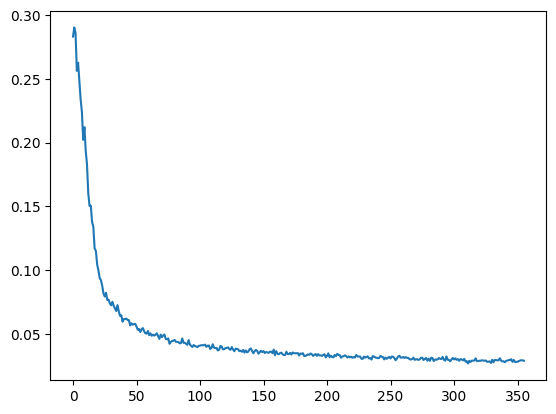

In [16]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
plt.plot(to_cpu(losses))

In [17]:
x, y = next(iter(val_loader))

In [18]:
x_hat, enc = ae(x.to(device))

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.92 GiB total capacity; 8.86 GiB already allocated; 11.69 MiB free; 8.90 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

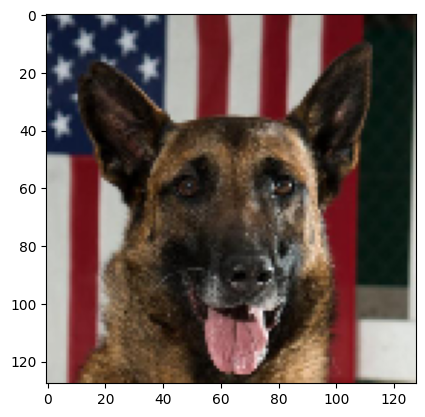

In [201]:
show_img(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


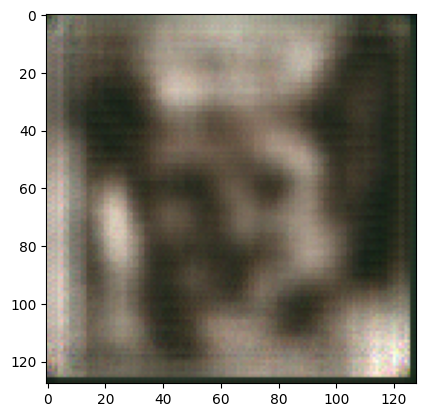

In [202]:
show_img(x_hat)